### Protein Family Classification

In [1]:
import numpy as np
import pandas as pd

import sklearn.utils
from sklearn.linear_model import LogisticRegression

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf

from lazy import lazy

import collections
import re

In [2]:
family_classification_metadata = pd.read_table('../seminar_5/data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('../seminar_5/data/family_classification_sequences.tab')

In [3]:
family_classification_metadata.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [4]:
family_classification_sequences.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [5]:
family_classification_metadata.describe()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
count,324018,324018,324018,324018,324018
unique,287308,295671,56951,7027,6967
top,Q1X881,POLG_DEN2J,UvrABC system protein B,MMR_HSR1,50S ribosome-binding GTPase
freq,16,12,1500,3084,3084


#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you

In [6]:
# Used to limit performance when cluster is loaded
CLUSTER_LIMIT = 10 ** 9

In [20]:
family_ids = np.array(family_classification_metadata['FamilyID'])
# Finding top-k by frequency: https://stackoverflow.com/a/19909411/5338270
unique_ids, positions = np.unique(family_ids, return_inverse=True)
top_thousand_indices = np.bincount(positions).argsort()[::-1][:1000]
top_two_indices = np.bincount(positions).argsort()[::-1][:2]
top_two_mask = np.in1d(positions, top_two_indices)[:CLUSTER_LIMIT]
top_thousand_mask = np.in1d(positions, top_thousand_indices)
top_two_mask_after_thousand = np.in1d(positions[top_thousand_mask], top_two_indices)
top_thousand_families = unique_ids[top_thousand_indices]

In [8]:
sequences_to_classify = np.array(family_classification_sequences)[top_thousand_mask][:CLUSTER_LIMIT]
family_ids_gt = family_ids[top_thousand_mask][:CLUSTER_LIMIT]
family_ids_gt = sklearn.preprocessing.LabelEncoder().fit_transform(family_ids_gt).reshape((len(sequences_to_classify), 1))
family_ids_gt = sklearn.preprocessing.OneHotEncoder(sparse=False).fit_transform(family_ids_gt)
print('Number of sequences: {}'.format(len(sequences_to_classify)))
print('Max length of sequence: {}'.format(np.apply_along_axis(lambda x: len(x[0]), 1, sequences_to_classify).max()))

Number of sequences: 261149
Max length of sequence: 22152


In [9]:
BATCH_SIZE = 64
NUM_CLASSES = 1000
MAX_RAW_LEN = 100 #np.apply_along_axis(lambda x: len(x[0]), 1, sequences_to_classify).max()
MAX_SEQ_LEN = (MAX_RAW_LEN + 2) // 3
NUM_EPOCHS = 1
EMBED_LEN = 100

In [10]:
# Pad sequences with spaces
sequences_to_classify = np.apply_along_axis(lambda x: x[0].ljust(MAX_RAW_LEN), 1, sequences_to_classify)

In [11]:
class MyEmbedding:
    def __init__(self):
        # Dirty code
        self._dict = dict()
        with open('final_embedding.txt', 'r') as fl:
            inp = fl.read().strip()
            
            while inp:
                trigram = inp[:3]
                start_arr = inp.index('[')
                end_arr = inp.index(']')
                values = eval(re.sub('\s+', ',', inp[start_arr+1:end_arr-1].strip()))
                values = np.array(values)
                self._dict[trigram] = values
                inp = inp[end_arr + 1:].lstrip()
    
    def lookup(self, trigram):
        return self._dict.get(trigram, np.zeros((100,)))

In [12]:
embedding = MyEmbedding()

In [13]:
# Transform strings to real sequences of vectors
def get_words(s):
    return [embedding.lookup(s[i:i+3]) for i in range(0, min(len(s), MAX_RAW_LEN), 3)]

sequences_to_classify = np.array(list(map(lambda s: get_words(s), sequences_to_classify)))

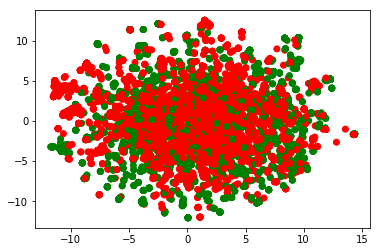

In [22]:
tsne = TSNE()
printable_seq = sequences_to_classify[top_two_mask_after_thousand]
printable_seq = np.mean(printable_seq, axis=2)

XX = tsne.fit_transform(printable_seq)

plt.figure()
plt.scatter(XX[:, 0], XX[:, 1], c=['red' if x == 'Helicase_C' else 'green' for x in family_ids[top_two_mask]])
plt.show()

In [23]:
class DNASequenceClassifier:
    def __init__(self, rnn_hidden_dim, learning_rate, gradient_clipping):
        self._rnn_hidden_dim = rnn_hidden_dim
        self._learning_rate = learning_rate
        self._gradient_clipping = gradient_clipping
        
        self._create_placeholders()
        
        self.prediction
        self.cost
        self.error
        self.optimize
        
        self._create_summaries()
        
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('error', self.error)
            self.summary = tf.summary.merge_all()
            self.saver = tf.train.Saver()
        
    def _create_placeholders(self):
        with tf.name_scope('data'):
            self.data = tf.placeholder(tf.float32, [None, MAX_SEQ_LEN, EMBED_LEN])
            self.target = tf.placeholder(tf.float32, [None, NUM_CLASSES])
        
    @staticmethod
    def _last_relevant(output):
        with tf.name_scope("last_relevant"):
            batch_size = tf.shape(output)[0]
            output_size = int(output.get_shape()[2])
            index = tf.range(0, batch_size) * MAX_SEQ_LEN + (MAX_SEQ_LEN - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant        
        
    @lazy
    def length(self):
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length        
        
    @lazy
    def prediction(self):
        with tf.name_scope('rnn'):
            output, _ = tf.nn.dynamic_rnn(
                tf.contrib.rnn.GRUCell(self._rnn_hidden_dim),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
            
            # [batch_size, time, dims]
            #last_out = tf.gather(output, MAX_SEQ_LEN - 1, axis=1)
            last_out = self._last_relevant(output)
            
            with tf.name_scope("softmax_layer"):
                weight = tf.Variable(tf.truncated_normal(
                    [self._rnn_hidden_dim, NUM_CLASSES], stddev=0.01))
                bias = tf.Variable(tf.constant(0.1))
                self._logits = tf.matmul(last_out, weight) + bias
                prediction = tf.nn.softmax(self._logits)
                
                return prediction
        
    @lazy
    def cost(self):
        with tf.name_scope('softmax'):
            return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.target,
                                                      logits=self._logits))
        
    @lazy
    def error(self):
        with tf.name_scope('accuracy'):
            self.mistakes = tf.not_equal(
                tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
            return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
        
    @lazy
    def optimize(self):
        with tf.name_scope("optimization"):
            optimizer=tf.train.AdamOptimizer(self._learning_rate)
            gradient = optimizer.compute_gradients(self.cost)
            limit = self._gradient_clipping
            gradient = [
                (tf.clip_by_value(g, -limit, limit), v)
                if g is not None else (None, v)
                for g, v in gradient]
            optimize = optimizer.apply_gradients(gradient)
            
        return optimize

In [24]:
X_train, X_test, y_train, y_test = train_test_split(sequences_to_classify, family_ids_gt)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(195861, 34, 100)
(195861, 1000)
(65288, 34, 100)
(65288, 1000)


In [25]:
baseline_cls = LogisticRegression()
baseline_cls.fit(np.mean(X_train, axis=2), np.argmax(y_train, axis=1))
print('Baseline score on test set: {}%'.format(100 * baseline_cls.score(np.mean(X_test, axis=2), 
                                                                 np.argmax(y_test, axis=1))))

Baseline score on test set: 9.758301678715844%


In [26]:
model = DNASequenceClassifier(rnn_hidden_dim=150, learning_rate=1.9, gradient_clipping=100)

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [27]:
config = tf.ConfigProto(
    device_count = {'GPU': 0},
)

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    ckpt = tf.train.get_checkpoint_state('checkpoints')
    if ckpt:
        model.saver.restore(sess, ckpt.model_checkpoint_path)

    for epoch in range(NUM_EPOCHS):
        sklearn.utils.shuffle(X_train, y_train)
        for i in range(0, len(X_train), BATCH_SIZE):
            feed_dict = {model.data: X_train[i:i+BATCH_SIZE], model.target: y_train[i:i+BATCH_SIZE]}
            cost, error, _, summary_str = sess.run([model.cost, model.error, model.optimize, model.summary], feed_dict=feed_dict)
            print('{} {}: {:3.1f}% loss={}'.format(epoch, i, 100 * (1 - error), cost))
        model.saver.save(sess, 'checkpoints/rnn', epoch)

    
    feed_dict = {model.data: X_test, model.target: y_test}
    
    total_accuracy, total_loss = sess.run([model.error, model.cost], feed_dict)
    print('Statistics on test set\nAccuracy: {}, loss: {}'.format(1 - total_accuracy, total_loss))

0 0: 0.0% loss=6.905633926391602
0 64: 1.6% loss=44.8148193359375
0 128: 0.0% loss=113.96856689453125
0 192: 0.0% loss=142.13223266601562
0 256: 0.0% loss=146.74081420898438
0 320: 1.6% loss=198.17124938964844
0 384: 0.0% loss=210.88250732421875
0 448: 0.0% loss=218.1688232421875
0 512: 0.0% loss=227.68014526367188
0 576: 0.0% loss=214.68008422851562
0 640: 0.0% loss=186.39028930664062
0 704: 0.0% loss=195.21859741210938
0 768: 0.0% loss=246.12547302246094
0 832: 0.0% loss=222.86288452148438
0 896: 0.0% loss=229.68618774414062
0 960: 0.0% loss=219.67108154296875
0 1024: 1.6% loss=220.36083984375
0 1088: 0.0% loss=187.25723266601562
0 1152: 0.0% loss=281.9941711425781
0 1216: 1.6% loss=229.94378662109375
0 1280: 0.0% loss=247.71170043945312
0 1344: 0.0% loss=261.5616149902344
0 1408: 0.0% loss=245.63841247558594
0 1472: 0.0% loss=272.01849365234375
0 1536: 0.0% loss=262.5372314453125
0 1600: 0.0% loss=270.33892822265625
0 1664: 1.6% loss=293.573974609375
0 1728: 0.0% loss=281.8377685546

0 14592: 0.0% loss=502.19757080078125
0 14656: 0.0% loss=525.631103515625
0 14720: 1.6% loss=487.80987548828125
0 14784: 0.0% loss=604.895751953125
0 14848: 0.0% loss=541.4725952148438
0 14912: 0.0% loss=526.7798461914062
0 14976: 0.0% loss=558.3496704101562
0 15040: 0.0% loss=589.7228393554688
0 15104: 0.0% loss=499.7005310058594
0 15168: 0.0% loss=506.6982116699219
0 15232: 0.0% loss=544.1301879882812
0 15296: 0.0% loss=487.08087158203125
0 15360: 0.0% loss=514.3948974609375
0 15424: 0.0% loss=502.1702575683594
0 15488: 0.0% loss=487.8880310058594
0 15552: 1.6% loss=441.6394348144531
0 15616: 0.0% loss=550.209228515625
0 15680: 0.0% loss=489.17431640625
0 15744: 0.0% loss=515.7572021484375
0 15808: 0.0% loss=510.11517333984375
0 15872: 0.0% loss=548.9410400390625
0 15936: 0.0% loss=523.1602172851562
0 16000: 1.6% loss=468.5233459472656
0 16064: 1.6% loss=582.1324462890625
0 16128: 0.0% loss=492.66400146484375
0 16192: 0.0% loss=524.92822265625
0 16256: 0.0% loss=522.7864379882812
0 1

0 29056: 3.1% loss=581.9493408203125
0 29120: 0.0% loss=577.2409057617188
0 29184: 0.0% loss=573.05029296875
0 29248: 0.0% loss=576.6043090820312
0 29312: 1.6% loss=533.6478881835938
0 29376: 0.0% loss=584.2247314453125
0 29440: 0.0% loss=480.37738037109375
0 29504: 1.6% loss=572.013671875
0 29568: 1.6% loss=625.3309326171875
0 29632: 0.0% loss=619.399169921875
0 29696: 0.0% loss=574.8731079101562
0 29760: 0.0% loss=496.3538513183594
0 29824: 1.6% loss=599.3886108398438
0 29888: 0.0% loss=474.96142578125
0 29952: 0.0% loss=585.484130859375
0 30016: 0.0% loss=482.3447265625
0 30080: 0.0% loss=581.10107421875
0 30144: 0.0% loss=551.1994018554688
0 30208: 0.0% loss=619.671142578125
0 30272: 0.0% loss=528.8349609375
0 30336: 0.0% loss=571.852783203125
0 30400: 0.0% loss=608.0645751953125
0 30464: 0.0% loss=566.5494995117188
0 30528: 1.6% loss=464.427490234375
0 30592: 0.0% loss=504.23406982421875
0 30656: 0.0% loss=585.673583984375
0 30720: 1.6% loss=544.3212890625
0 30784: 0.0% loss=570.8

0 43520: 0.0% loss=629.2017822265625
0 43584: 3.1% loss=498.4095764160156
0 43648: 0.0% loss=514.08544921875
0 43712: 1.6% loss=565.5523681640625
0 43776: 0.0% loss=568.3910522460938
0 43840: 1.6% loss=532.7064819335938
0 43904: 1.6% loss=494.77685546875
0 43968: 3.1% loss=498.410400390625
0 44032: 1.6% loss=589.3225708007812
0 44096: 0.0% loss=540.5029296875
0 44160: 1.6% loss=562.997802734375
0 44224: 3.1% loss=452.89691162109375
0 44288: 0.0% loss=458.1025695800781
0 44352: 1.6% loss=536.037841796875
0 44416: 0.0% loss=536.6107788085938
0 44480: 3.1% loss=470.0561218261719
0 44544: 0.0% loss=544.5997314453125
0 44608: 0.0% loss=489.157958984375
0 44672: 0.0% loss=632.86865234375
0 44736: 3.1% loss=542.4271240234375
0 44800: 1.6% loss=567.45556640625
0 44864: 0.0% loss=596.72900390625
0 44928: 1.6% loss=509.1915283203125
0 44992: 0.0% loss=513.618896484375
0 45056: 0.0% loss=537.2626953125
0 45120: 0.0% loss=464.6429748535156
0 45184: 1.6% loss=500.0497131347656
0 45248: 0.0% loss=57

0 57984: 0.0% loss=568.5528564453125
0 58048: 4.7% loss=440.73199462890625
0 58112: 0.0% loss=531.3967895507812
0 58176: 3.1% loss=528.8580932617188
0 58240: 0.0% loss=594.5125122070312
0 58304: 1.6% loss=646.9207763671875
0 58368: 1.6% loss=550.89697265625
0 58432: 0.0% loss=547.1934814453125
0 58496: 3.1% loss=550.096923828125
0 58560: 3.1% loss=449.120361328125
0 58624: 3.1% loss=522.0927124023438
0 58688: 3.1% loss=414.373291015625
0 58752: 6.2% loss=478.10235595703125
0 58816: 1.6% loss=540.837158203125
0 58880: 3.1% loss=562.349609375
0 58944: 3.1% loss=508.0720520019531
0 59008: 0.0% loss=525.4559326171875
0 59072: 0.0% loss=484.5270080566406
0 59136: 0.0% loss=542.97705078125
0 59200: 3.1% loss=491.70098876953125
0 59264: 1.6% loss=471.25335693359375
0 59328: 4.7% loss=459.6478576660156
0 59392: 3.1% loss=541.2764892578125
0 59456: 4.7% loss=549.4293212890625
0 59520: 1.6% loss=591.541748046875
0 59584: 1.6% loss=434.7328186035156
0 59648: 0.0% loss=567.27099609375
0 59712: 0.0

0 72384: 1.6% loss=643.5065307617188
0 72448: 1.6% loss=435.1595458984375
0 72512: 4.7% loss=509.3985595703125
0 72576: 3.1% loss=524.1297607421875
0 72640: 0.0% loss=544.65625
0 72704: 0.0% loss=533.709716796875
0 72768: 0.0% loss=532.4818115234375
0 72832: 1.6% loss=563.0733032226562
0 72896: 3.1% loss=546.11962890625
0 72960: 1.6% loss=610.8358764648438
0 73024: 0.0% loss=587.8959350585938
0 73088: 1.6% loss=516.8707885742188
0 73152: 3.1% loss=545.3005981445312
0 73216: 0.0% loss=578.235595703125
0 73280: 3.1% loss=507.1549072265625
0 73344: 1.6% loss=705.8018798828125
0 73408: 4.7% loss=516.052734375
0 73472: 0.0% loss=593.481689453125
0 73536: 3.1% loss=617.2744140625
0 73600: 0.0% loss=566.8367919921875
0 73664: 1.6% loss=566.5869140625
0 73728: 4.7% loss=589.7449340820312
0 73792: 3.1% loss=564.19580078125
0 73856: 0.0% loss=478.1378173828125
0 73920: 1.6% loss=503.1376953125
0 73984: 0.0% loss=497.32476806640625
0 74048: 0.0% loss=526.5748291015625
0 74112: 3.1% loss=550.32031

0 86848: 0.0% loss=444.42156982421875
0 86912: 4.7% loss=614.3081665039062
0 86976: 4.7% loss=436.410888671875
0 87040: 4.7% loss=490.12933349609375
0 87104: 3.1% loss=577.695068359375
0 87168: 3.1% loss=533.865966796875
0 87232: 3.1% loss=438.20074462890625
0 87296: 1.6% loss=574.7261962890625
0 87360: 1.6% loss=589.9083251953125
0 87424: 3.1% loss=446.49530029296875
0 87488: 4.7% loss=542.6939697265625
0 87552: 3.1% loss=552.3549194335938
0 87616: 1.6% loss=642.6332397460938
0 87680: 0.0% loss=555.50244140625
0 87744: 0.0% loss=497.7597351074219
0 87808: 0.0% loss=554.51220703125
0 87872: 1.6% loss=705.7926635742188
0 87936: 3.1% loss=509.91534423828125
0 88000: 1.6% loss=593.3302001953125
0 88064: 3.1% loss=476.4548645019531
0 88128: 0.0% loss=517.7396240234375
0 88192: 3.1% loss=412.084228515625
0 88256: 0.0% loss=571.6387939453125
0 88320: 3.1% loss=479.690185546875
0 88384: 0.0% loss=516.1282348632812
0 88448: 1.6% loss=540.1209716796875
0 88512: 3.1% loss=632.7937622070312
0 885

0 101184: 3.1% loss=565.5831298828125
0 101248: 1.6% loss=521.0823974609375
0 101312: 3.1% loss=549.6759033203125
0 101376: 1.6% loss=628.89501953125
0 101440: 0.0% loss=658.3040771484375
0 101504: 1.6% loss=525.629638671875
0 101568: 0.0% loss=634.0140380859375
0 101632: 1.6% loss=540.22802734375
0 101696: 1.6% loss=624.9733276367188
0 101760: 3.1% loss=521.3219604492188
0 101824: 0.0% loss=680.4566040039062
0 101888: 3.1% loss=602.7232055664062
0 101952: 3.1% loss=467.00360107421875
0 102016: 0.0% loss=519.8580322265625
0 102080: 0.0% loss=636.6156005859375
0 102144: 1.6% loss=498.40240478515625
0 102208: 0.0% loss=452.2527160644531
0 102272: 0.0% loss=562.5711669921875
0 102336: 0.0% loss=745.5075073242188
0 102400: 0.0% loss=564.43603515625
0 102464: 0.0% loss=615.75390625
0 102528: 0.0% loss=582.7881469726562
0 102592: 0.0% loss=570.2500610351562
0 102656: 4.7% loss=528.4197998046875
0 102720: 1.6% loss=631.6123046875
0 102784: 1.6% loss=593.2123413085938
0 102848: 1.6% loss=612.6

0 115328: 1.6% loss=747.4736938476562
0 115392: 0.0% loss=637.53759765625
0 115456: 1.6% loss=552.392822265625
0 115520: 0.0% loss=671.6473388671875
0 115584: 3.1% loss=651.857421875
0 115648: 0.0% loss=658.8408203125
0 115712: 0.0% loss=575.0885009765625
0 115776: 0.0% loss=634.1788940429688
0 115840: 0.0% loss=617.2215576171875
0 115904: 1.6% loss=587.265380859375
0 115968: 0.0% loss=616.50390625
0 116032: 3.1% loss=524.748779296875
0 116096: 0.0% loss=514.5521850585938
0 116160: 0.0% loss=629.9902954101562
0 116224: 1.6% loss=560.071533203125
0 116288: 0.0% loss=557.678466796875
0 116352: 0.0% loss=644.8565673828125
0 116416: 3.1% loss=552.2900390625
0 116480: 0.0% loss=571.212158203125
0 116544: 0.0% loss=578.580322265625
0 116608: 0.0% loss=676.315185546875
0 116672: 1.6% loss=517.782958984375
0 116736: 0.0% loss=690.248046875
0 116800: 0.0% loss=682.81640625
0 116864: 0.0% loss=660.5166015625
0 116928: 1.6% loss=612.0682373046875
0 116992: 0.0% loss=566.2531127929688
0 117056: 0.

0 129472: 1.6% loss=519.572998046875
0 129536: 0.0% loss=683.0750732421875
0 129600: 4.7% loss=440.5312194824219
0 129664: 0.0% loss=639.4837646484375
0 129728: 1.6% loss=560.4559326171875
0 129792: 0.0% loss=587.4354248046875
0 129856: 0.0% loss=645.641845703125
0 129920: 0.0% loss=544.338134765625
0 129984: 0.0% loss=549.1189575195312
0 130048: 1.6% loss=643.6885375976562
0 130112: 0.0% loss=594.634765625
0 130176: 3.1% loss=576.1284790039062
0 130240: 0.0% loss=603.45703125
0 130304: 1.6% loss=469.6466064453125
0 130368: 3.1% loss=577.4782104492188
0 130432: 0.0% loss=573.267333984375
0 130496: 3.1% loss=569.3642578125
0 130560: 3.1% loss=534.7295532226562
0 130624: 1.6% loss=615.14453125
0 130688: 0.0% loss=501.6462707519531
0 130752: 0.0% loss=642.9820556640625
0 130816: 4.7% loss=700.7049560546875
0 130880: 0.0% loss=505.8197326660156
0 130944: 0.0% loss=544.4833374023438
0 131008: 1.6% loss=637.5188598632812
0 131072: 0.0% loss=573.7554321289062
0 131136: 0.0% loss=549.277709960

0 143552: 1.6% loss=523.8907470703125
0 143616: 1.6% loss=604.5079345703125
0 143680: 0.0% loss=569.7554931640625
0 143744: 0.0% loss=546.9838256835938
0 143808: 3.1% loss=506.252685546875
0 143872: 6.2% loss=560.3101806640625
0 143936: 0.0% loss=561.37451171875
0 144000: 0.0% loss=644.1529541015625
0 144064: 1.6% loss=510.62628173828125
0 144128: 1.6% loss=552.1287231445312
0 144192: 1.6% loss=554.1619873046875
0 144256: 3.1% loss=479.4259033203125
0 144320: 3.1% loss=468.0029602050781
0 144384: 1.6% loss=496.051025390625
0 144448: 0.0% loss=580.340576171875
0 144512: 3.1% loss=547.05322265625
0 144576: 0.0% loss=607.0579833984375
0 144640: 1.6% loss=499.429931640625
0 144704: 0.0% loss=529.856201171875
0 144768: 1.6% loss=539.8302001953125
0 144832: 1.6% loss=602.4177856445312
0 144896: 1.6% loss=509.7823181152344
0 144960: 1.6% loss=531.8756103515625
0 145024: 3.1% loss=474.39971923828125
0 145088: 0.0% loss=528.7770385742188
0 145152: 4.7% loss=499.114990234375
0 145216: 3.1% loss=

0 157696: 0.0% loss=489.59161376953125
0 157760: 4.7% loss=474.48028564453125
0 157824: 0.0% loss=604.74755859375
0 157888: 0.0% loss=563.457763671875
0 157952: 1.6% loss=514.6410522460938
0 158016: 0.0% loss=509.4040832519531
0 158080: 1.6% loss=595.1285400390625
0 158144: 0.0% loss=577.145751953125
0 158208: 0.0% loss=644.777587890625
0 158272: 4.7% loss=400.7411804199219
0 158336: 3.1% loss=537.3564453125
0 158400: 1.6% loss=591.8134765625
0 158464: 0.0% loss=569.693603515625
0 158528: 0.0% loss=567.3040771484375
0 158592: 3.1% loss=598.7703857421875
0 158656: 1.6% loss=505.59429931640625
0 158720: 1.6% loss=574.072509765625
0 158784: 3.1% loss=553.9028930664062
0 158848: 1.6% loss=582.9446411132812
0 158912: 0.0% loss=656.177490234375
0 158976: 0.0% loss=523.3963623046875
0 159040: 3.1% loss=579.0484619140625
0 159104: 1.6% loss=553.3738403320312
0 159168: 1.6% loss=418.18780517578125
0 159232: 0.0% loss=716.36328125
0 159296: 7.8% loss=456.8714599609375
0 159360: 1.6% loss=609.594

0 171712: 0.0% loss=626.8427734375
0 171776: 1.6% loss=527.457275390625
0 171840: 1.6% loss=494.84906005859375
0 171904: 0.0% loss=581.1236572265625
0 171968: 1.6% loss=543.4795532226562
0 172032: 0.0% loss=488.347412109375
0 172096: 0.0% loss=648.0374755859375
0 172160: 3.1% loss=675.1663208007812
0 172224: 3.1% loss=574.35791015625
0 172288: 0.0% loss=504.8417053222656
0 172352: 1.6% loss=555.030517578125
0 172416: 3.1% loss=551.11767578125
0 172480: 3.1% loss=602.8037719726562
0 172544: 1.6% loss=600.8037109375
0 172608: 1.6% loss=599.61083984375
0 172672: 0.0% loss=550.86962890625
0 172736: 1.6% loss=592.49267578125
0 172800: 0.0% loss=653.8133544921875
0 172864: 1.6% loss=531.7583618164062
0 172928: 3.1% loss=540.0924682617188
0 172992: 3.1% loss=508.49578857421875
0 173056: 0.0% loss=632.7291870117188
0 173120: 0.0% loss=517.4580078125
0 173184: 0.0% loss=697.8841552734375
0 173248: 1.6% loss=535.84326171875
0 173312: 1.6% loss=570.94580078125
0 173376: 0.0% loss=568.1552734375
0

0 185792: 1.6% loss=609.139892578125
0 185856: 1.6% loss=691.8328247070312
0 185920: 1.6% loss=605.0977172851562
0 185984: 1.6% loss=608.5433959960938
0 186048: 3.1% loss=559.622802734375
0 186112: 3.1% loss=697.387451171875
0 186176: 0.0% loss=585.0279541015625
0 186240: 0.0% loss=608.8011474609375
0 186304: 1.6% loss=508.3853759765625
0 186368: 1.6% loss=680.783447265625
0 186432: 1.6% loss=636.6888427734375
0 186496: 3.1% loss=626.989501953125
0 186560: 0.0% loss=699.6165161132812
0 186624: 3.1% loss=390.2835693359375
0 186688: 3.1% loss=508.21685791015625
0 186752: 0.0% loss=583.1695556640625
0 186816: 0.0% loss=529.2476806640625
0 186880: 1.6% loss=642.34814453125
0 186944: 1.6% loss=591.5191650390625
0 187008: 0.0% loss=635.6949462890625
0 187072: 0.0% loss=608.7736206054688
0 187136: 0.0% loss=687.8236694335938
0 187200: 1.6% loss=604.9122924804688
0 187264: 0.0% loss=714.386474609375
0 187328: 0.0% loss=597.7301025390625
0 187392: 0.0% loss=595.8550415039062
0 187456: 1.6% loss

ValueError: Parent directory of checkpoints/rnn doesn't exist, can't save.